# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [ ]:
%%capture
# this is github gist URL, there are all functions I need to reuse often across many notebooks
!wget -O package.py https://gist.githubusercontent.com/Jankoetf/c36cc24ddd83d4194148a86f87efd397/raw/d1fd57e295b92e083bdcb2299f7c2155a1932ad4/package1.py;
from package import basic_preprocessing

In [ ]:
dataset = pd.read_csv('jobfair_train.csv')
dataset = basic_preprocessing(dataset)
print(dataset.shape)

(55314, 20)


# Corelation, Feature importance Analysis

## Corelations, features with high corelation

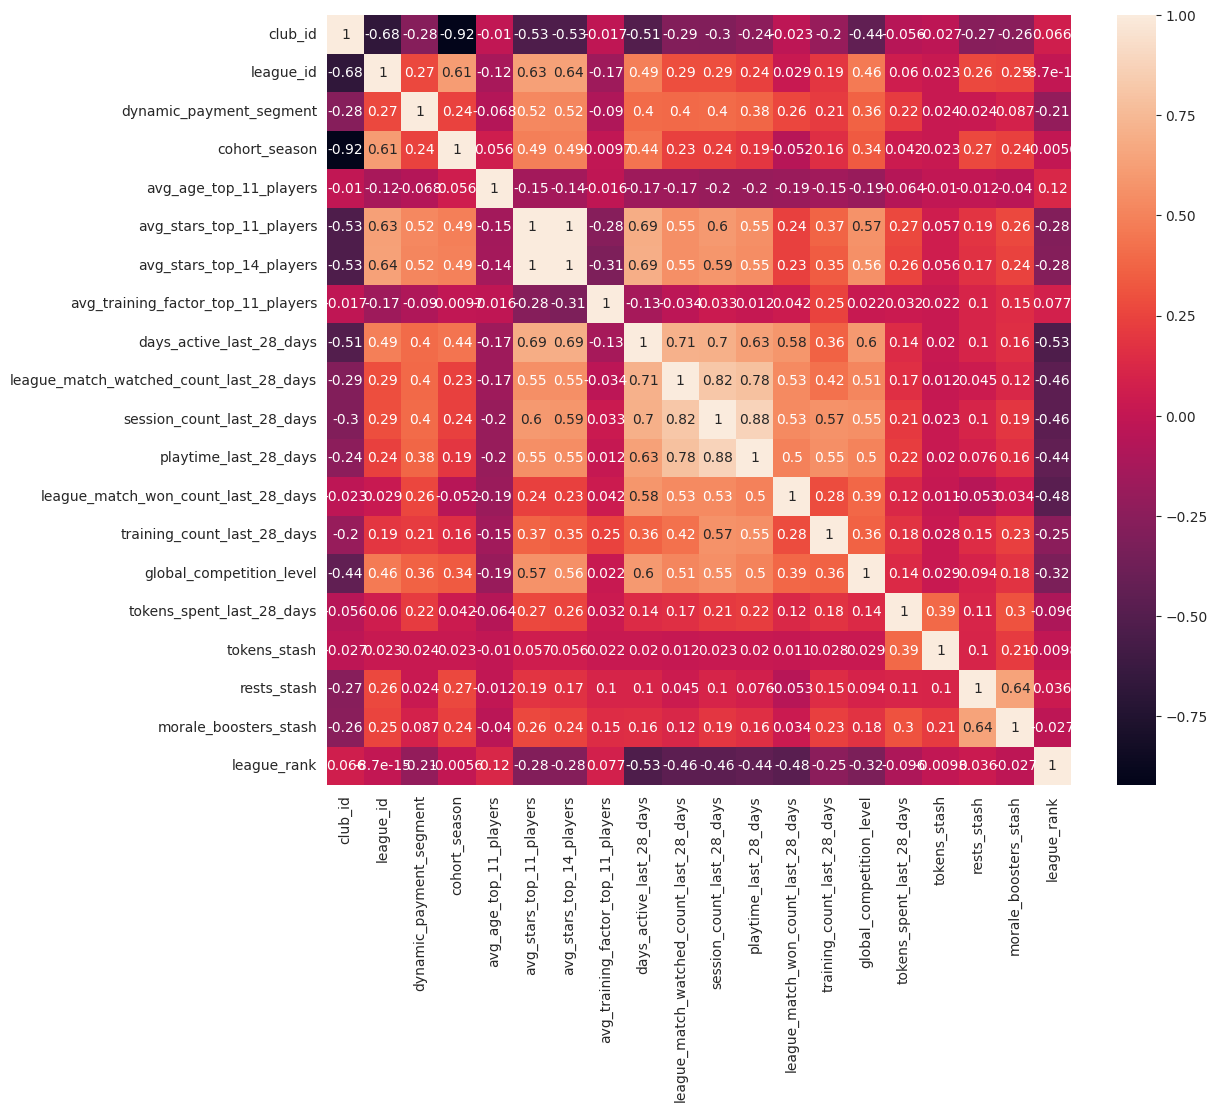

In [ ]:
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
corr_matrix = dataset.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

### Visualizing different corelations

In [ ]:
dataset.columns

Index(['club_id', 'league_id', 'dynamic_payment_segment', 'cohort_season',
       'avg_age_top_11_players', 'avg_stars_top_11_players',
       'avg_stars_top_14_players', 'avg_training_factor_top_11_players',
       'days_active_last_28_days', 'league_match_watched_count_last_28_days',
       'session_count_last_28_days', 'playtime_last_28_days',
       'league_match_won_count_last_28_days', 'training_count_last_28_days',
       'global_competition_level', 'tokens_spent_last_28_days', 'tokens_stash',
       'rests_stash', 'morale_boosters_stash', 'league_rank'],
      dtype='object')

In [ ]:
dataset_2D_1 = dataset[['playtime_last_28_days', 'session_count_last_28_days', 'league_rank']].copy()
dataset_2D_2 = dataset[['playtime_last_28_days', 'league_match_won_count_last_28_days', 'league_rank']].copy()
dataset_2D_3 = dataset[['playtime_last_28_days', 'avg_stars_top_11_players', 'league_rank']].copy()
dataset_2D_4 = dataset[['playtime_last_28_days', 'training_count_last_28_days', 'league_rank']].copy()
dataset_2D_5 = dataset[['playtime_last_28_days', 'tokens_spent_last_28_days', 'league_rank']].copy()
dataset_2D_6 = dataset[['playtime_last_28_days', 'league_id', 'league_rank']].copy()
dataset_2D_7 = dataset[['playtime_last_28_days', 'avg_training_factor_top_11_players', 'league_rank']].copy()

In [ ]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
def plotting(data):
    sc = StandardScaler()
    X_train = sc.fit_transform(data.iloc[:,:-1].values)
    y_train = data.iloc[:, -1].values

    for i, j in enumerate(np.unique(y_train)):
        plt.scatter(X_train[y_train == j, 0], X_train[y_train == j, 1], label = j)

    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[1])
    plt.legend()
    plt.show()

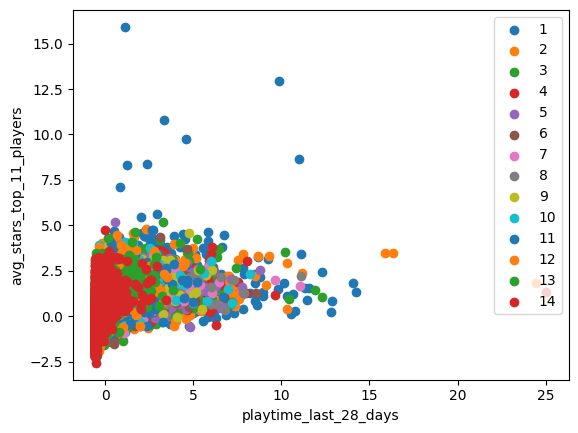

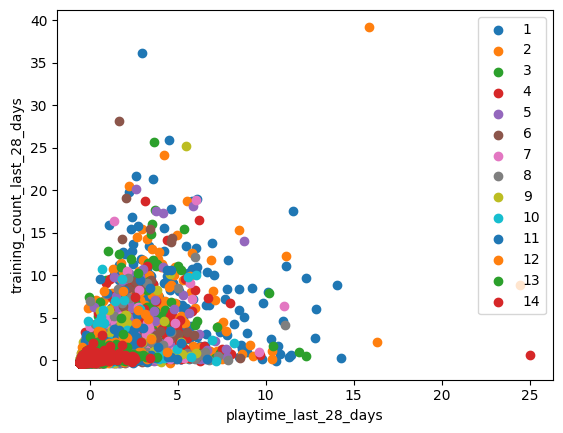

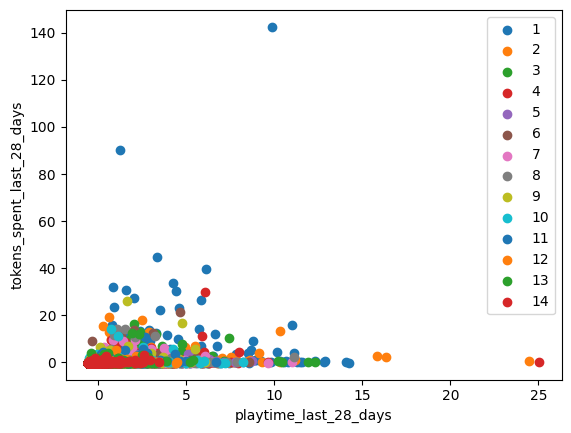

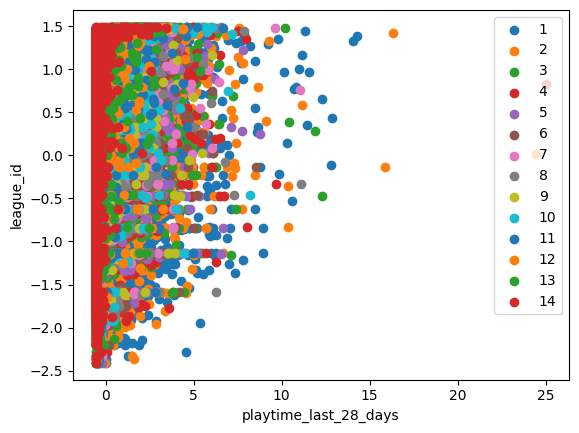

In [ ]:
#plotting(dataset_2D_1)
#plotting(dataset_2D_2)
plotting(dataset_2D_3)
plotting(dataset_2D_4)
plotting(dataset_2D_5)
plotting(dataset_2D_6)
#plotting(dataset_2D_7)

## Feature Importances

In [ ]:
X_train_all = dataset.iloc[:, :-1]
y_train_all = dataset.iloc[:, -1]

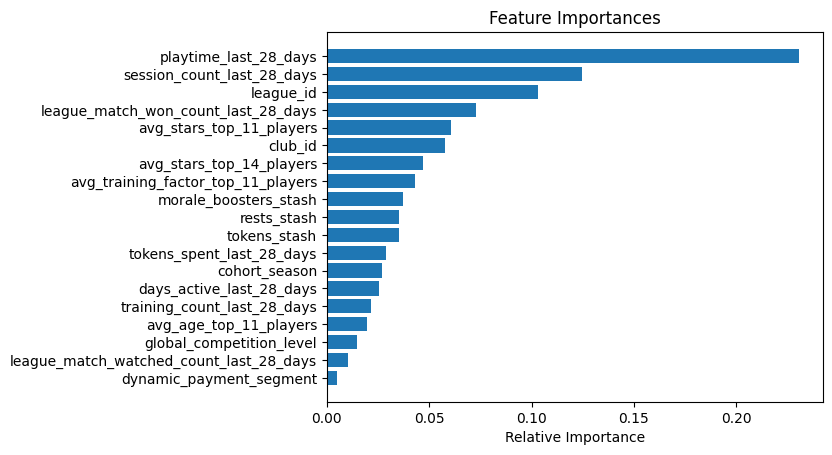

In [ ]:
model = RandomForestRegressor()
model.fit(X_train_all, y_train_all)
importances = model.feature_importances_

# Plotting Feature Importances
features = X_train_all.columns
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Corelations with target variable

In [ ]:
correlation_matrix = dataset.corr()
target_correlation = correlation_matrix['league_rank']
target_correlation = target_correlation.drop(labels=['league_rank'])

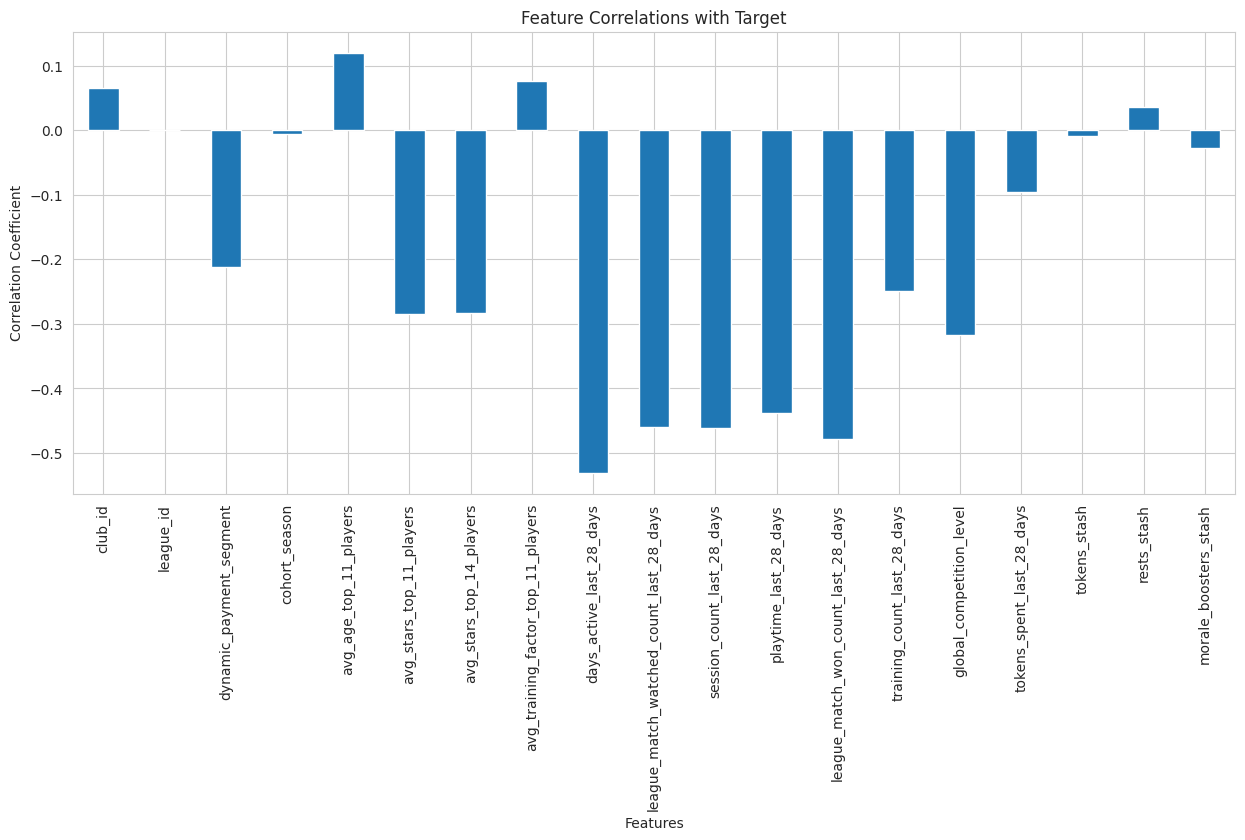

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 6))
target_correlation.plot(kind='bar')
plt.title('Feature Correlations with Target')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.show()

# Features Selection

- Features **average stars top 14 players and average stars top 11 players** have perfect positive corelation between them so one must go, when looking into features importances we see that average stars top 11 is more important, so top 14 has to go
****
- Features **cohort season and club id** have almost perfect negative corelation between them, but club id have bigger corelation with target and is more important when looking into features importances, so cohort season has to go
****
- Even in my best tunned XGBoost model features which has lowest relative importances was: dynamic_payment_segment with 0.014054
tokens_stash with 0.013390, rests_stash with 0.012409, league_match_watched_count_last_28_days with 0.011026, here in RandomForestRegressor model we see lowest are dynamic_payment_segment, league_match_watched_count_last_28_days, global_competition level, and average_age_top_11_players, but this features show different levels of linear correlation with target variable so I will experiment.


In [ ]:
def Feature_Selection(data):
    data = data.drop('avg_stars_top_14_players', axis = 1)
    data = data.drop('cohort_season', axis = 1)
    return data
def Radical_Feature_Selection(data):
    data = Feature_Selection(data)
    data = data.drop('tokens_stash', axis = 1)
    data = data.drop('rests_stash', axis = 1)
    return data
def Super_Radical_Feature_Selection(data):
    data = Feature_Selection(data)
    data = data.drop('dynamic_payment_segment', axis = 1)
    data = data.drop('league_match_watched_count_last_28_days', axis = 1)
    return data

I tried neural network without feature selection and with it.
**I have to emphasize that there is no real difference in MAE with no or with feature selection, and also there is no real difference between using one or other feature selection function**. I found that first function **Feature_Selection**, works slightly better then others.

# Feature Ingineering

To help model learn relationships within one league it may be helpfull to transform all features that highly depend on league_id into features relative to league average. For example in better leagues clubs spent more money in game by average than in bottom leagues, so averaging this feature by league might help model make better predictions.
****
After that I will drop original feature

In [ ]:
def Averaging_by_leagues(data):
    list_of_features = data.columns.tolist()
    list_of_features.remove('league_rank')
    list_of_features.remove('league_id')
    for feature in list_of_features:
        updated_feature = dataset.groupby('league_id')[feature].transform('mean')
        data['averaged_' + feature] = data[feature] / updated_feature
        data['averaged_' + feature].fillna(0, inplace = True)
        data = data.drop(feature, axis = 1)
    return data

Now there is a question whether I should drop league_rank from dataset, because there is no corelation between league_id and target variable, but league_id have high importance so it will be spared.

# Experimentation

**I tested before neural network for this task without feature ingineering, feature selection etc, and I get MAE around 2.35**. In this segment I will try different combination of data selection, data ingineering, custom train-val-test splits, postprocesing functions, to see what works the best

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## Basic approach

In [ ]:
'''import'''
dataset = pd.read_csv('jobfair_train.csv')

'''preprocesing'''
dataset = basic_preprocessing(dataset)
dataset = Feature_Selection(dataset)
dataset = Averaging_by_leagues(dataset)
print(dataset.shape)

(55314, 18)


In [ ]:
y = dataset['league_rank'].iloc[:].values
dataset = dataset.drop('league_rank', axis = 1)
X = dataset.iloc[:, :].values

print(y.shape)
print(X.shape)

(55314,)
(55314, 17)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [ ]:
best_model = Sequential()
best_model.add(Dense(10, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
best_model.add(Dense(10, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
best_model.add(Dense(1, activation='linear'))
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['mae'])

In [ ]:
best_model.fit(X_train, y_train, batch_size = 14, epochs = 25, \
        validation_data=(X_val, y_val), callbacks=[early_stopping])

In [ ]:
raw_predictions_train = best_model.predict(X_train)
raw_predictions_val = best_model.predict(X_val)
raw_predictions_test = best_model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
print("train")
mae_train = mean_absolute_error(y_train, raw_predictions_train)
print(f"Mean Absolute Error - predictions - val set: {mae_train}")
print("val")
mae_val = mean_absolute_error(y_val, raw_predictions_val)
print(f"Mean Absolute Error - predictions - val set: {mae_val}")
print("test")
mae_test = mean_absolute_error(y_test, raw_predictions_test)
print(f"Mean Absolute Error - predictions - val set: {mae_test}")

train
Mean Absolute Error - predictions - val set: 1.9404832640539666
val
Mean Absolute Error - predictions - val set: 1.9938256595533586
test
Mean Absolute Error - predictions - val set: 1.9922563867031808


**Feature Ingineering** alone reduces MAE for 0.35, which is absolutely great.

### Post_processing

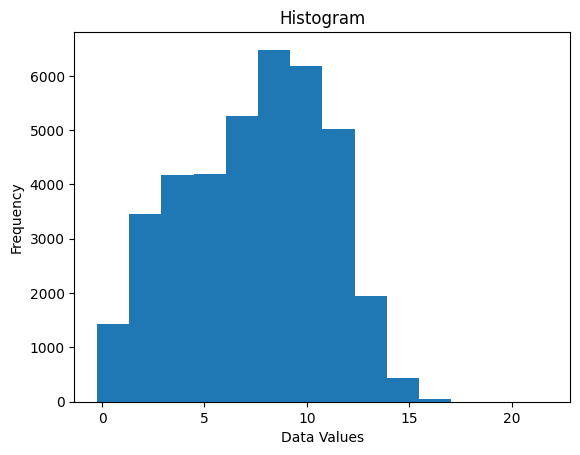

In [ ]:
plt.hist(raw_predictions_train, bins=14)
plt.title('Histogram')
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.show()

We see that predictions are conservative in a way that most of them are oround 7.5. Of course if we have for all predictions 7.5 MAE will be 3.5, But if model is unsertain obout prediction, the safest is to predict exactly 7.5. This is regular when dealing with regressions when MAE is loss.

In [ ]:
print(max(raw_predictions_train))
print(min(raw_predictions_train))
print(np.mean(raw_predictions_train))
percentage_greater_than_threshold = np.sum(raw_predictions_train > 14) / len(raw_predictions_train) * 100
print(f"Percentage of values greater than {14}: {percentage_greater_than_threshold:.2f}%")

[21.76304]
[-0.2472806]
7.4729066
Percentage of values greater than 14: 1.07%


The idea is to transform float prediction values into int values, also there are predictions less than 1 and bigger than 14.

In [ ]:
def post_processing(y_pred):
    for i in range(len(y_pred)):
        if y_pred[i] < 1: y_pred[i] = 1
        elif y_pred[i] > 14: y_pred[i] = 14
        else: y_pred[i] = np.round(y_pred[i])

In [ ]:
post_processing(raw_predictions_train)
post_processing(raw_predictions_val)
post_processing(raw_predictions_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
print("train")
mae_train = mean_absolute_error(y_train, raw_predictions_train)
print(f"Mean Absolute Error - predictions - val set: {mae_train}")
print("val")
mae_val = mean_absolute_error(y_val, raw_predictions_val)
print(f"Mean Absolute Error - predictions - val set: {mae_val}")
print("test")
mae_test = mean_absolute_error(y_test, raw_predictions_test)
print(f"Mean Absolute Error - predictions - val set: {mae_test}")

train
Mean Absolute Error - predictions - val set: 1.9163908141098582
val
Mean Absolute Error - predictions - val set: 1.9717028172525555
test
Mean Absolute Error - predictions - val set: 1.967300556586271


This way the MAE is reduced a little bit.

## **Custom** dataset split aproach

Idea is to first sort dataset by league_id, by this dataset will be grouped by league_id - 14 clubs with same league_id will all be neighbors. After that dataset will be splitted into train, val, test sets but group property should stay.

Optional: groups could be shuffled across all sets

This way I can easily write a function that assigns values
 to clubs from 1 to 14 inside one league.

Problem with this aproach I cant use standard crossvalidation with GridSearch, I would need to write these functions manualy.

For submision I will need to sort by league_id again.

In [ ]:
def train_val_test_split_adapted(data):
    list_of_choices = np.random.choice([0,1,2], size = int(data.shape[0] / 14), p = [0.7, 0.15, 0.15])

    index_league_rank = data.columns.get_loc('league_rank')
    X = data.iloc[:,:].values
    train_set, val_set, test_set = [], [], []

    for i, choice in enumerate(list_of_choices):
        if choice == 0:
                train_set.append(X[14*i:(i+1)*14, :])
        elif choice == 1:
                val_set.append(X[14*i:(i+1)*14, :])
        else:
                test_set.append(X[14*i:(i+1)*14, :])

    train_set, val_set, test_set = np.concatenate(train_set), np.concatenate(val_set), np.concatenate(test_set)

    return (np.concatenate((train_set[:, :index_league_rank], train_set[:, index_league_rank+1:]), axis=1),
            train_set[:, index_league_rank],
            np.concatenate((val_set[:, :index_league_rank], val_set[:, index_league_rank+1:]), axis=1),
            val_set[:, index_league_rank],
            np.concatenate((test_set[:, :index_league_rank], test_set[:, index_league_rank+1:]), axis=1),
            test_set[:, index_league_rank]
            )

In [ ]:
def train_val_test_split_adapted_shuffled(data):
    list_of_choices = np.random.choice([0,1,2], size = int(data.shape[0] / 14), p = [0.7, 0.15, 0.15])
    permutation = np.arange(int(data.shape[0] / 14))
    np.random.shuffle(permutation)


    index_league_rank = data.columns.get_loc('league_rank')
    X = data.iloc[:,:].values
    train_set, val_set, test_set = [], [], []

    for p in permutation:
        if list_of_choices[p] == 0:
                train_set.append(X[14*p:(p+1)*14, :])
        elif list_of_choices[p] == 1:
                val_set.append(X[14*p:(p+1)*14, :])
        else:
                test_set.append(X[14*p:(p+1)*14, :])

    train_set, val_set, test_set = np.concatenate(train_set), np.concatenate(val_set), np.concatenate(test_set)

    return (np.concatenate((train_set[:, :index_league_rank], train_set[:, index_league_rank+1:]), axis=1),
            train_set[:, index_league_rank],
            np.concatenate((val_set[:, :index_league_rank], val_set[:, index_league_rank+1:]), axis=1),
            val_set[:, index_league_rank],
            np.concatenate((test_set[:, :index_league_rank], test_set[:, index_league_rank+1:]), axis=1),
            test_set[:, index_league_rank]
            )
#X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split_adapted(dataset)

Post_sorting - in one league predictions are assigned from 1 to 14 in order in which are raw_predictions.

In [ ]:
import copy
def one_post_process(y_p):
    y_p_copy = y_p[:]
    temp = np.argsort(np.array(y_p))
    for i in range(len(y_p)):
        y_p_copy[temp[i]] = i + 1
    return y_p_copy

def post_sorting(y_pred, length):
    y_prediction = copy.deepcopy(y_pred)
    n = int(len(y_prediction) / length)

    for i in range(n):
        y_prediction[i*length:(i+1)*length] = one_post_process(y_prediction[i*length:(i+1)*length])

    return y_prediction

### Testing **adapted dataset split** aproach

In [ ]:
'''import'''
dataset = pd.read_csv('jobfair_train.csv')

'''sorting'''
dataset = dataset.sort_values(by='league_id')

'''preprocesing'''
dataset = basic_preprocessing(dataset)
dataset = Feature_Selection(dataset)
dataset = Averaging_by_leagues(dataset)
print(dataset.shape)

(55314, 18)


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split_adapted(dataset)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [ ]:
best_model = Sequential()
best_model.add(Dense(10, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
best_model.add(Dense(10, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
best_model.add(Dense(1, activation='linear'))
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['mae'])

Trying **14 for batch_size** might also be helpfull, idea is to tell neural network to learn group by group of 14 clubs.

In [ ]:
best_model.fit(X_train, y_train, batch_size = 14, epochs = 25, \
        validation_data=(X_val, y_val), callbacks=[early_stopping])

In [ ]:
raw_predictions_train = best_model.predict(X_train)
raw_predictions_val = best_model.predict(X_val)
raw_predictions_test = best_model.predict(X_test)

257/257 [==============================] - 1s 4ms/step


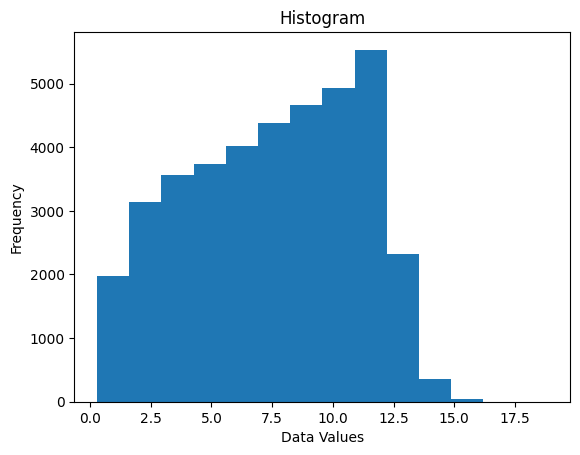

In [ ]:
plt.hist(raw_predictions_train, bins=14)
plt.title('Histogram')
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(max(raw_predictions_train))
print(min(raw_predictions_train))
print(np.mean(raw_predictions_train))
percentage_greater_than_threshold = np.sum(raw_predictions_train > 14) / len(raw_predictions_train) * 100
print(f"Percentage of values greater than {14}: {percentage_greater_than_threshold:.2f}%")

[18.85849]
[0.2813369]
7.506053
Percentage of values greater than 14: 0.50%


In [ ]:
from sklearn.metrics import mean_absolute_error
print("train")
mae_train = mean_absolute_error(y_train, raw_predictions_train)
print(f"Mean Absolute Error - predictions - val set: {mae_train}")
print("val")
mae_val = mean_absolute_error(y_val, raw_predictions_val)
print(f"Mean Absolute Error - predictions - val set: {mae_val}")
print("test")
mae_test = mean_absolute_error(y_test, raw_predictions_test)
print(f"Mean Absolute Error - predictions - val set: {mae_test}")

train
Mean Absolute Error - predictions - val set: 1.9317277383043463
val
Mean Absolute Error - predictions - val set: 1.926677947564307
test
Mean Absolute Error - predictions - val set: 1.9631972586684319


### Postprocesing predictions

In [ ]:
post_processing(raw_predictions_train)
post_processing(raw_predictions_val)
post_processing(raw_predictions_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
print("train")
mae_train = mean_absolute_error(y_train, raw_predictions_train)
print(f"Mean Absolute Error - predictions - val set: {mae_train}")
print("val")
mae_val = mean_absolute_error(y_val, raw_predictions_val)
print(f"Mean Absolute Error - predictions - val set: {mae_val}")
print("test")
mae_test = mean_absolute_error(y_test, raw_predictions_test)
print(f"Mean Absolute Error - predictions - val set: {mae_test}")

train
Mean Absolute Error - predictions - val set: 1.914477086997
val
Mean Absolute Error - predictions - val set: 1.913882966121772
test
Mean Absolute Error - predictions - val set: 1.946977084349098


We see that this aproach is slightly better that with regular train test split. But there is also small overfitting, probably because all train, val and test splits are sorted by league_id.

### Post-sorting predictions

In [ ]:
raw_predictions_train = best_model.predict(X_train)
raw_predictions_val = best_model.predict(X_val)
raw_predictions_test = best_model.predict(X_test)

predictions_train = post_sorting(raw_predictions_train, 14)
predictions_val = post_sorting(raw_predictions_val, 14)
predictions_test = post_sorting(raw_predictions_test, 14)

257/257 [==============================] - 1s 2ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error
print("train - sorted")
mae_train = mean_absolute_error(y_train, predictions_train)
print(f"Mean Absolute Error - predictions - val set: {mae_train}")
print("val - sorted")
mae_val = mean_absolute_error(y_val, predictions_val)
print(f"Mean Absolute Error - predictions - val set: {mae_val}")
print("test - sorted")
mae_test = mean_absolute_error(y_test, predictions_test)
print(f"Mean Absolute Error - predictions - val set: {mae_test}")

train - sorted
Mean Absolute Error - predictions - val set: 2.2412330609289337
val - sorted
Mean Absolute Error - predictions - val set: 2.289454001495886
test - sorted
Mean Absolute Error - predictions - val set: 2.293483302411874


It looks like post_sorting doesnt work here

### Testing adapted shuffled dataset split aproach

In [ ]:
'''import'''
dataset = pd.read_csv('jobfair_train.csv')

'''sorting'''
dataset = dataset.sort_values(by='league_id')

'''preprocesing'''
dataset = basic_preprocessing(dataset)
dataset = Feature_Selection(dataset)
dataset = Averaging_by_leagues(dataset)
print(dataset.shape)

(55314, 18)


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split_adapted_shuffled(dataset)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [ ]:
best_model = Sequential()
best_model.add(Dense(10, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
best_model.add(Dense(10, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
best_model.add(Dense(1, activation='linear'))
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error', metrics=['mae'])

In [ ]:
best_model.fit(X_train, y_train, batch_size = 14, epochs = 25, \
        validation_data=(X_val, y_val), callbacks=[early_stopping])

In [ ]:
raw_predictions_train = best_model.predict(X_train)
raw_predictions_val = best_model.predict(X_val)
raw_predictions_test = best_model.predict(X_test)

273/273 [==============================] - 0s 2ms/step


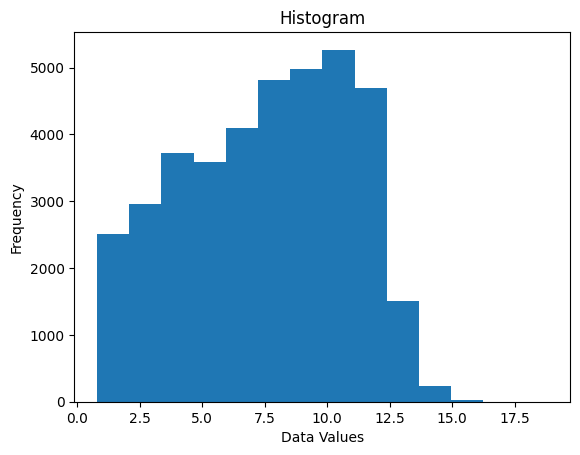

In [ ]:
plt.hist(raw_predictions_train, bins=14)
plt.title('Histogram')
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.show()

In [ ]:
print(max(raw_predictions_train))
print(min(raw_predictions_train))
print(np.mean(raw_predictions_train))
percentage_greater_than_threshold = np.sum(raw_predictions_train > 14) / len(raw_predictions_train) * 100
print(f"Percentage of values greater than {14}: {percentage_greater_than_threshold:.2f}%")

[18.83007]
[0.7812001]
7.5324883
Percentage of values greater than 14: 0.40%


In [ ]:
from sklearn.metrics import mean_absolute_error
print("train")
mae_train = mean_absolute_error(y_train, raw_predictions_train)
print(f"Mean Absolute Error - predictions - val set: {mae_train}")
print("val")
mae_val = mean_absolute_error(y_val, raw_predictions_val)
print(f"Mean Absolute Error - predictions - val set: {mae_val}")
print("test")
mae_test = mean_absolute_error(y_test, raw_predictions_test)
print(f"Mean Absolute Error - predictions - val set: {mae_test}")

train
Mean Absolute Error - predictions - val set: 1.9501949597644244
val
Mean Absolute Error - predictions - val set: 1.9325169102394537
test
Mean Absolute Error - predictions - val set: 1.946121141850962


### Postprocesing predictions

In [ ]:
post_processing(raw_predictions_train)
post_processing(raw_predictions_val)
post_processing(raw_predictions_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
print("train")
mae_train = mean_absolute_error(y_train, raw_predictions_train)
print(f"Mean Absolute Error - predictions - val set: {mae_train}")
print("val")
mae_val = mean_absolute_error(y_val, raw_predictions_val)
print(f"Mean Absolute Error - predictions - val set: {mae_val}")
print("test")
mae_test = mean_absolute_error(y_test, raw_predictions_test)
print(f"Mean Absolute Error - predictions - val set: {mae_test}")

train
Mean Absolute Error - predictions - val set: 1.9326597573043072
val
Mean Absolute Error - predictions - val set: 1.911843711843712
test
Mean Absolute Error - predictions - val set: 1.9352212795230452


We see that this aproach is slightly better that with regular train test split. Also now with shuffle it seems there is **less overfitting** then in adapted aproach without shuffling.

### Post-sorting predictions

In [ ]:
raw_predictions_train = best_model.predict(X_train)
raw_predictions_val = best_model.predict(X_val)
raw_predictions_test = best_model.predict(X_test)

predictions_train = post_sorting(raw_predictions_train, 14)
predictions_val = post_sorting(raw_predictions_val, 14)
predictions_test = post_sorting(raw_predictions_test, 14)

273/273 [==============================] - 0s 1ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error
print("train - sorted")
mae_train = mean_absolute_error(y_train, predictions_train)
print(f"Mean Absolute Error - predictions - val set: {mae_train}")
print("val - sorted")
mae_val = mean_absolute_error(y_val, predictions_val)
print(f"Mean Absolute Error - predictions - val set: {mae_val}")
print("test - sorted")
mae_test = mean_absolute_error(y_test, predictions_test)
print(f"Mean Absolute Error - predictions - val set: {mae_test}")

train - sorted
Mean Absolute Error - predictions - val set: 2.2771000431795354
val - sorted
Mean Absolute Error - predictions - val set: 2.254429317204798
test - sorted
Mean Absolute Error - predictions - val set: 2.252659628702068


Agian post_sorting doesnt work here

# Conclusion

**Feature Selection** only helps with dimension reduction and it has low impact on MAE.

**Feature ingineering** is the real winner here, without it MAE is around 2.3 - 2.4 - and with it MAE drops to 2.0 - 1.95, which is massive for just one function.

**Custom Splits** are usefull but they complicate things a lot, they require more code and more time, also they will strongly complicate future crossvalidations and hyper-parameters tunning. Of cource custom split with shuffle is better then one without it because of overfitting.

**Post Procesing function** helps and it is only logical way of testing model performance

**Post Sorting Function** doesnt work - the reason is probably that there are a lot of unsertain predictions, in other cases I guess it would have a strong impact